In [1]:
import os
import zipfile
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define paths (MODIFY THESE TO MATCH YOUR ACTUAL FILE PATHS)
drive_root = '/content/drive/MyDrive/'  # Adjust if your files are in a subfolder
train_zip_path = os.path.join(drive_root, 'training_set.zip')
train_csv_path = os.path.join(drive_root, 'training_set_pixel_size_and_HC.csv')

# Verify files exist
print("Checking if files exist...")
print(f"Train zip exists: {os.path.exists(train_zip_path)}")
print(f"Train CSV exists: {os.path.exists(train_csv_path)}")

# Create directories
base_dir = '/content/data'
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
train_images_dir = os.path.join(train_dir, 'images')
train_masks_dir = os.path.join(train_dir, 'masks')

os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_masks_dir, exist_ok=True)

# Extract training data
print("\nExtracting training data...")
try:
    with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
        zip_ref.extractall(train_dir)
    print("Training data extracted successfully!")
    print("Contents of train directory:")
    print(os.listdir(train_dir))
except Exception as e:
    print(f"Error extracting training data: {e}")

# Load CSV file
print("\nLoading CSV file...")
try:
    train_csv = pd.read_csv(train_csv_path)
    print("Training CSV loaded successfully!")
    print(f"Found {len(train_csv)} entries in training CSV")
except Exception as e:
    print(f"Error loading training CSV: {e}")
    train_csv = None

# Organize files with more robust checking
print("\nOrganizing files...")

def find_files(directory, pattern):
    """Find all files in directory matching pattern"""
    matches = []
    for root, _, files in os.walk(directory):
        for f in files:
            if f.endswith(pattern):
                matches.append(os.path.join(root, f))
    return matches

# Find all PNGs in train directory
train_pngs = find_files(train_dir, '.png')
print(f"Found {len(train_pngs)} PNG files in train directory")

# Move files to appropriate folders
moved_images = 0
moved_masks = 0

for filepath in train_pngs:
    filename = os.path.basename(filepath)
    try:
        if '_Annotation' in filename:
            new_path = os.path.join(train_masks_dir, filename)
            os.rename(filepath, new_path)
            moved_masks += 1
        else:
            new_path = os.path.join(train_images_dir, filename)
            os.rename(filepath, new_path)
            moved_images += 1
    except Exception as e:
        print(f"Error moving {filename}: {e}")

print(f"Moved {moved_images} images to {train_images_dir}")
print(f"Moved {moved_masks} masks to {train_masks_dir}")

# Final verification
print("\nFinal verification:")
print(f"Training images: {len(os.listdir(train_images_dir))}")
print(f"Training masks: {len(os.listdir(train_masks_dir))}")

if train_csv is not None:
    print("\nSample training CSV data:")
    print(train_csv.head())


Mounted at /content/drive
Checking if files exist...
Train zip exists: True
Train CSV exists: True

Extracting training data...
Training data extracted successfully!
Contents of train directory:
['training_set', 'images', 'masks']

Loading CSV file...
Training CSV loaded successfully!
Found 999 entries in training CSV

Organizing files...
Found 1998 PNG files in train directory
Moved 999 images to /content/data/train/images
Moved 999 masks to /content/data/train/masks

Final verification:
Training images: 999
Training masks: 999

Sample training CSV data:
     filename  pixel size(mm)  head circumference (mm)
0  000_HC.png        0.069136                    44.30
1  001_HC.png        0.089659                    56.81
2  002_HC.png        0.062033                    68.75
3  003_HC.png        0.091291                    69.00
4  004_HC.png        0.061240                    59.81


Found 999 images and 999 masks

Sample 1:
Image: 000_HC.png
Mask: 000_HC_Annotation.png


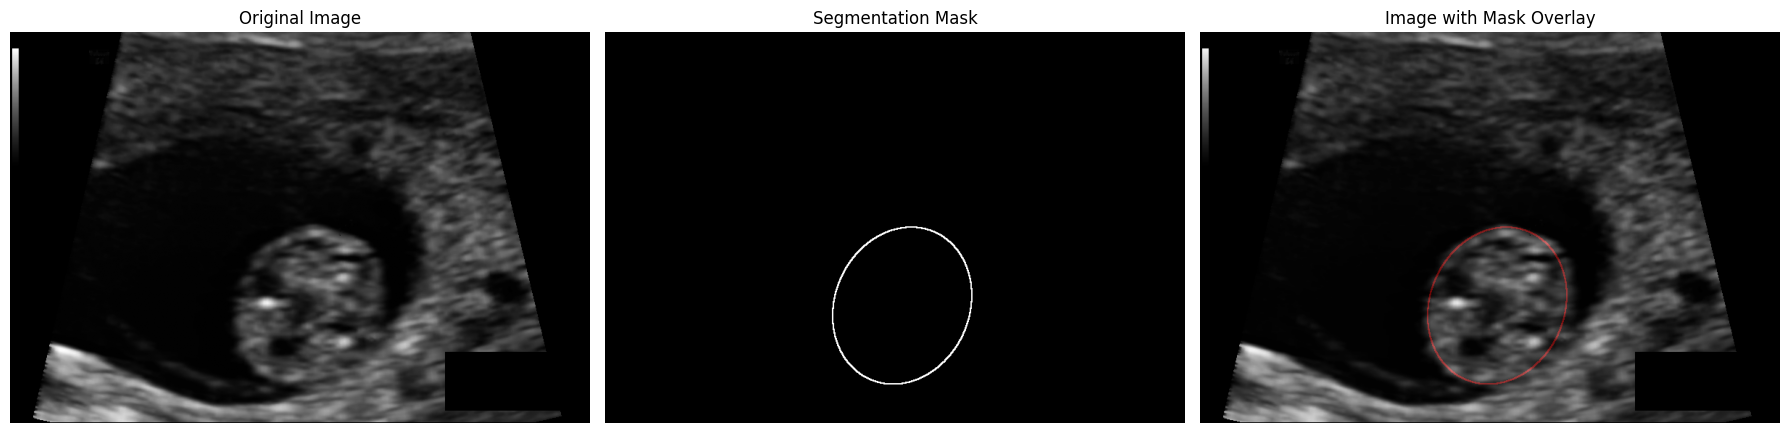


Sample 2:
Image: 001_HC.png
Mask: 001_HC_Annotation.png


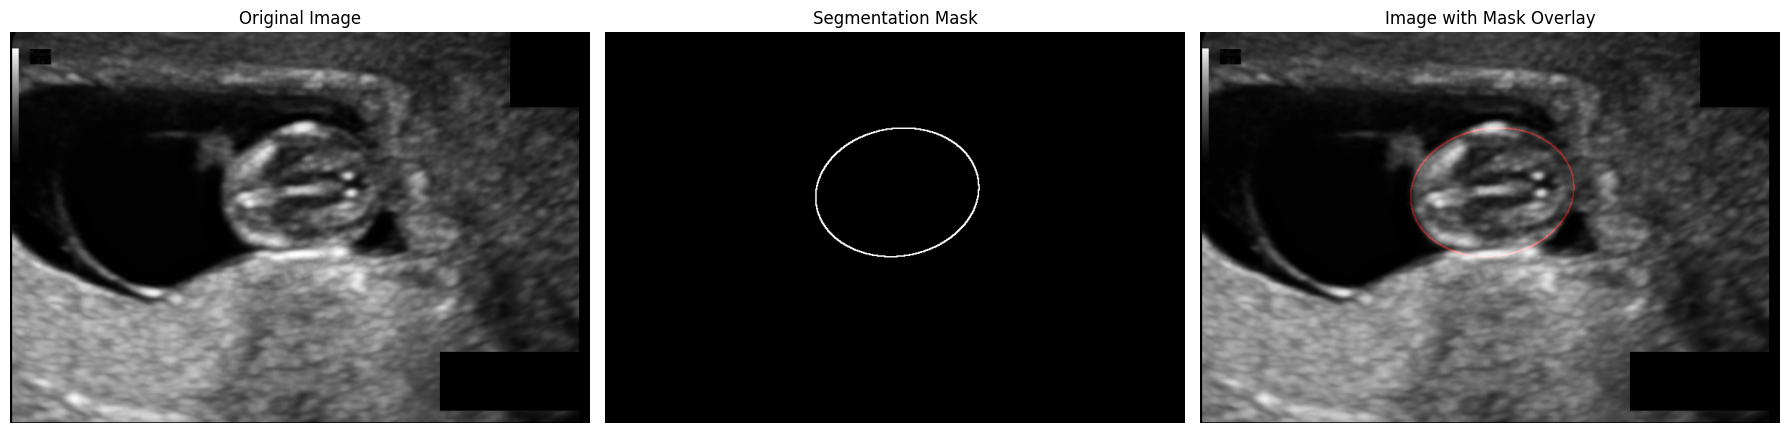


Sample 3:
Image: 002_HC.png
Mask: 002_HC_Annotation.png


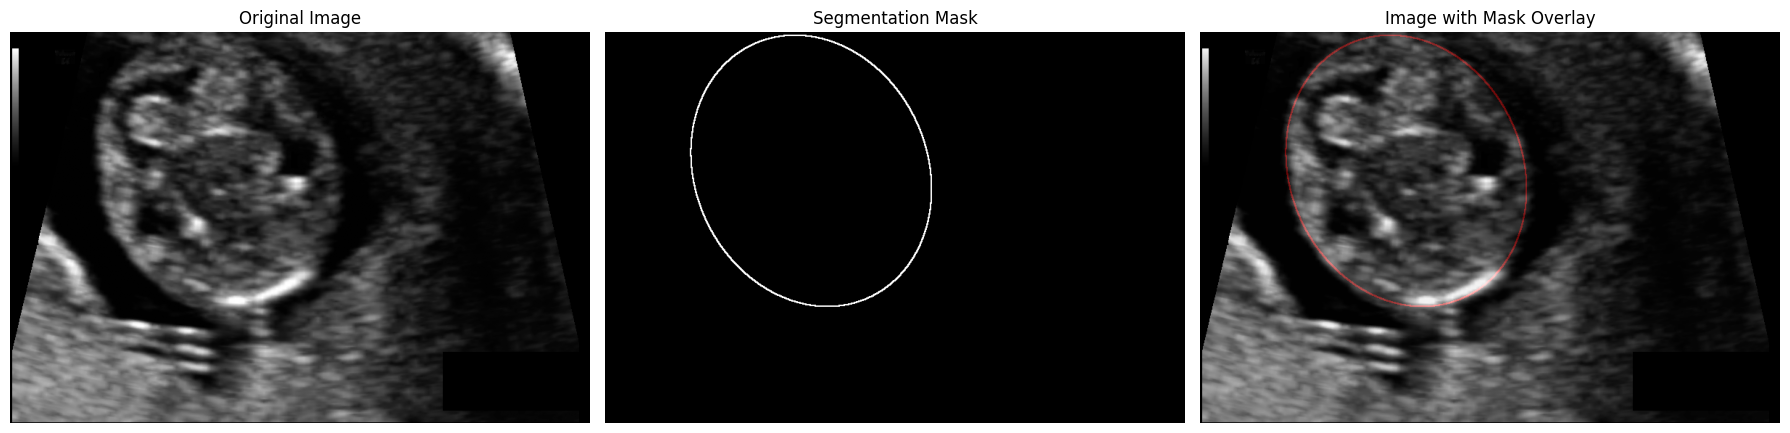

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from glob import glob

# Set paths (modify if needed)
train_images_dir = '/content/data/train/images'
train_masks_dir = '/content/data/train/masks'

# Get sample images and masks
image_files = sorted(glob(os.path.join(train_images_dir, '*.png')))
mask_files = sorted(glob(os.path.join(train_masks_dir, '*_Annotation.png')))

# Verify we have matching pairs
if len(image_files) == 0 or len(mask_files) == 0:
    print("No images or masks found! Check your paths:")
    print(f"Images path: {train_images_dir}")
    print(f"Masks path: {train_masks_dir}")
else:
    print(f"Found {len(image_files)} images and {len(mask_files)} masks")

# Display function
def display_image_with_mask(image_path, mask_path, alpha=0.4):
    """Display image with mask overlay"""
    # Read images
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if image is None or mask is None:
        print(f"Could not read {image_path} or {mask_path}")
        return

    # Create colored mask (red in this case)
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    colored_mask[mask > 0] = [255, 0, 0]  # Red color

    # Convert grayscale image to RGB for visualization
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Overlay mask
    overlayed = cv2.addWeighted(image_rgb, 1, colored_mask, alpha, 0)

    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Display original image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Display mask
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Segmentation Mask')
    axes[1].axis('off')

    # Display overlay
    axes[2].imshow(overlayed)
    axes[2].set_title('Image with Mask Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Display first few samples
num_samples = min(3, len(image_files))
for i in range(num_samples):
    print(f"\nSample {i+1}:")
    print(f"Image: {os.path.basename(image_files[i])}")
    print(f"Mask: {os.path.basename(mask_files[i])}")
    display_image_with_mask(image_files[i], mask_files[i])

In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage import exposure
import albumentations as A
from sklearn.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt
from glob import glob # Import glob to find files

# Configuration for 256x256 images
class Config:
    TARGET_SIZE = (256, 256)
    INPUT_IMAGES_DIR = '/content/data/train/images'
    INPUT_MASKS_DIR = '/content/data/train/masks'
    OUTPUT_DIR = '/content/data/split_preprocessed_256'  # This is likely already correct

    AUGMENT = True
    NUM_AUGMENTATIONS = 5
    TEST_SIZE = 0.2
    VAL_SIZE = 0.2
    RANDOM_STATE = 42

# Create output directories
for subset in ['train', 'val', 'test']:
    for data_type in ['images', 'masks']:
        os.makedirs(os.path.join(Config.OUTPUT_DIR, subset, data_type), exist_ok=True)

class DataPreprocessor:
    def __init__(self):
        self.class_stats = defaultdict(list)
        self.augmentation_pipeline = self._create_augmentation_pipeline()

    def _create_augmentation_pipeline(self):
        """Create augmentation pipeline with foreground preservation"""
        return A.Compose([
            # Geometric transformations (adjusted limits for smaller images)
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=30, p=0.5, interpolation=cv2.INTER_NEAREST),  # Reduced rotation limit
            A.ShiftScaleRotate(
                shift_limit=0.05,  # Smaller shifts for 256x256 images
                scale_limit=0.1,  # Slightly smaller scaling for smaller images
                rotate_limit=20,  # Reduced rotation for smaller images
                p=0.5,
                interpolation=cv2.INTER_NEAREST
            ),

            # Intensity transformations (same as before)
            A.RandomBrightnessContrast(
                brightness_limit=0.1,
                contrast_limit=0.1,
                p=0.3
            ),
            A.CLAHE(clip_limit=3.0, p=0.3),
            A.GaussNoise(var_limit=5.0, p=0.1),

            # Foreground-specific augmentations (adjusted for smaller images)
            A.OneOf([
                A.ElasticTransform(
                    alpha=0.3,  # Reduced deformation
                    sigma=15,   # Smaller sigma
                    alpha_affine=8,  # Smaller affine
                    p=0.2,
                    interpolation=cv2.INTER_NEAREST
                ),
                A.GridDistortion(
                    num_steps=2,  # Fewer steps
                    distort_limit=0.08,  # Smaller distortion
                    p=0.2,
                    interpolation=cv2.INTER_NEAREST
                ),
            ], p=0.3),
        ], additional_targets={'mask': 'mask'})

    # All other methods remain the same except for _enhance_foreground adjustments
    def _enhance_foreground(self, image, mask):
        """Apply techniques to enhance visibility of rare foreground - adjusted for 256x256"""
        if np.mean(mask) < 0.01:
            fg_pixels = image[mask > 0]
            if len(fg_pixels) > 5:  # Smaller threshold for smaller images
                p2, p98 = np.percentile(fg_pixels, (2, 98))
                if p98 - p2 > 3:  # Smaller contrast range
                    image = exposure.rescale_intensity(
                        image,
                        in_range=(p2, p98),
                        out_range=(0, 255)
                    ).astype(np.uint8)

            # More conservative gamma for smaller images
            gamma = np.clip(0.6 + np.random.rand()*0.3, 0.6, 0.9)
            image = exposure.adjust_gamma(image, gamma=gamma)

            # Smaller kernel for sharpening
            if np.random.rand() > 0.7:
                kernel = np.array([[-1,-1,-1], [-1,10,-1], [-1,-1,-1]]) / 10.0
                fg_regions = cv2.bitwise_and(image, image, mask=mask.astype(np.uint8))
                sharpened = cv2.filter2D(fg_regions, -1, kernel)
                image = cv2.addWeighted(image, 0.85, sharpened, 0.15, 0)  # More conservative mixing
                image = np.clip(image, 0, 255)

        return image, mask

    def process_dataset(self):
        """Process and split the dataset."""
        image_files = sorted(glob(os.path.join(Config.INPUT_IMAGES_DIR, '*.png')))
        mask_files = sorted(glob(os.path.join(Config.INPUT_MASKS_DIR, '*.png')))

        # Assuming image and mask files have a 1-to-1 correspondence based on sorting
        data_pairs = list(zip(image_files, mask_files))

        # Split into train, validation, and test sets
        train_pairs, test_pairs = train_test_split(data_pairs, test_size=Config.TEST_SIZE, random_state=Config.RANDOM_STATE)
        train_pairs, val_pairs = train_test_split(train_pairs, test_size=Config.VAL_SIZE / (1 - Config.TEST_SIZE), random_state=Config.RANDOM_STATE)

        # Process and save each subset
        self._process_subset(train_pairs, 'train')
        self._process_subset(val_pairs, 'val')
        self._process_subset(test_pairs, 'test')

    def _process_subset(self, pairs, subset):
        """Process and save a subset (train, val, or test)."""
        for image_path, mask_path in tqdm(pairs, desc=f"Processing {subset}"):
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Resize to target size
            image = cv2.resize(image, Config.TARGET_SIZE, interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask, Config.TARGET_SIZE, interpolation=cv2.INTER_NEAREST)

            # Enhance foreground (if enabled)
            image, mask = self._enhance_foreground(image, mask)

            # Data augmentation (if enabled)
            if Config.AUGMENT and subset == 'train':
                for i in range(Config.NUM_AUGMENTATIONS): # Define i in loop for _save_image_mask_pair
                    augmented = self.augmentation_pipeline(image=image, mask=mask)
                    self._save_image_mask_pair(augmented['image'], augmented['mask'], subset, image_path, mask_path, is_augmented=True) # Pass image_path and mask_path to _save_image_mask_pair

            # Save original (and augmented if applicable) image and mask
            self._save_image_mask_pair(image, mask, subset, image_path, mask_path) # Pass image_path and mask_path to _save_image_mask_pair

    def _save_image_mask_pair(self, image, mask, subset, image_path, mask_path, is_augmented=False): # Added image_path and mask_path as arguments
        """Save image and mask to the appropriate directory."""
        filename_base = os.path.splitext(os.path.basename(image_path))[0]
        if is_augmented:
            filename_base += f"_aug_{i}"  # Add augmentation index to filename

        image_output_path = os.path.join(Config.OUTPUT_DIR, subset, 'images', f"{filename_base}.png")
        mask_output_path = os.path.join(Config.OUTPUT_DIR, subset, 'masks', f"{filename_base}.png")

        cv2.imwrite(image_output_path, image)
        cv2.imwrite(mask_output_path, mask)


    # All other methods remain identical (they'll automatically use the new TARGET_SIZE)

# Run the preprocessing pipeline
if __name__ == "__main__":
    preprocessor = DataPreprocessor()
    preprocessor.process_dataset()


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-3-2cc7ad18aa3b>:57: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=5.0, p=0.1),
<ipython-input-3-2cc7ad18aa3b>:61: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(
Processing test: 100%|██████████| 200/200 [00:01<00:00, 121.49it/s]


In [6]:
!pip install segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.3 MB/s eta 0:00:00


In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
import matplotlib.pyplot as plt
import cv2
from google.colab import drive

# Constants
INPUT_SHAPE = (256, 256, 1)
BATCH_SIZE = 4
EPOCHS = 100
INIT_LR = 1e-4
SEED = 42

# Mount Google Drive (for saving best model)
drive.mount('/content/drive')

# Data Generator
class SegmentationDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=BATCH_SIZE, shuffle=True, augment=False):
        self.image_paths = np.array(image_paths)
        self.mask_paths = np.array(mask_paths)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index*self.batch_size:(index+1)*self.batch_size]
        batch_mask_paths = self.mask_paths[index*self.batch_size:(index+1)*self.batch_size]

        images = []
        masks = []

        for img_path, mask_path in zip(batch_image_paths, batch_mask_paths):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if img is None or mask is None:
                print(f"Warning: Could not read image or mask from {img_path} or {mask_path}")
                continue

            # Add channel dimension
            img = np.expand_dims(img, axis=-1)
            mask = np.expand_dims(mask, axis=-1)

            # Normalize
            img = img.astype(np.float32) / 255.0
            mask = mask.astype(np.float32) / 255.0

            # Simple augmentation
            if self.augment:
                img, mask = self.apply_augmentation(img, mask)

            images.append(img)
            masks.append(mask)

        if len(images) == 0:
            return np.zeros((self.batch_size, *INPUT_SHAPE)), np.zeros((self.batch_size, *INPUT_SHAPE))

        return np.array(images), np.array(masks)

    def apply_augmentation(self, img, mask):
        # Random flip
        if np.random.rand() > 0.5:
            img = np.fliplr(img)
            mask = np.fliplr(mask)
        if np.random.rand() > 0.5:
            img = np.flipud(img)
            mask = np.flipud(mask)
        return img, mask

    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.image_paths))
            np.random.shuffle(indices)
            self.image_paths = self.image_paths[indices]
            self.mask_paths = self.mask_paths[indices]

# Model Architecture
def conv_block(x, filters, kernel_size=3, strides=1, activation='relu'):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    return x

def bottleneck_block(x, filters, strides=1):
    residual = x
    x = conv_block(x, filters//4, 1, strides)
    x = conv_block(x, filters//4, 3)
    x = conv_block(x, filters, 1, activation=None)

    if strides != 1 or residual.shape[-1] != filters:
        residual = conv_block(residual, filters, 1, strides, activation=None)

    x = tf.keras.layers.Add()([x, residual])
    return tf.keras.layers.Activation('relu')(x)

def hr_module(x, branches, filters):
    parallel_streams = []
    for i in range(branches):
        if i == 0:
            stream = x
        else:
            stream = tf.keras.layers.AveragePooling2D(pool_size=2**i)(x)
            stream = conv_block(stream, filters*(2**i))
            stream = tf.keras.layers.UpSampling2D(size=2**i, interpolation='bilinear')(stream)
        parallel_streams.append(stream)

    fused = tf.keras.layers.Concatenate()(parallel_streams)
    return conv_block(fused, filters)

def build_hrnet(input_shape=(256, 256, 1), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)

    # Stem
    x = conv_block(inputs, 64, 3, 2)  # 128x128
    x = conv_block(x, 64, 3, 2)       # 64x64

    # Stage 1
    x = bottleneck_block(x, 256)

    # HRNet Stages
    x = hr_module(x, branches=2, filters=32)
    x = hr_module(x, branches=3, filters=64)
    x = hr_module(x, branches=4, filters=128)

    # Final layers
    x = conv_block(x, 256, 1)

    # Upsampling
    x = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)  # 128x128
    x = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)    # 256x256

    # Output
    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Metrics and Losses
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Training function
def train_model(data_dir, output_dir='results'):
    os.makedirs(output_dir, exist_ok=True)

    # Define paths for each split
    splits = ['train', 'val', 'test']
    data_paths = {}

    for split in splits:
        image_dir = os.path.join(data_dir, split, 'images')
        mask_dir = os.path.join(data_dir, split, 'masks')

        image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
        mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

        assert len(image_paths) == len(mask_paths), f"Mismatch in number of images and masks for {split}"
        data_paths[split] = (image_paths, mask_paths)

    # Create generators
    train_gen = SegmentationDataGenerator(data_paths['train'][0], data_paths['train'][1], augment=True)
    val_gen = SegmentationDataGenerator(data_paths['val'][0], data_paths['val'][1], shuffle=False)
    test_gen = SegmentationDataGenerator(data_paths['test'][0], data_paths['test'][1], shuffle=False)

    # Build and compile model
    model = build_hrnet(input_shape=INPUT_SHAPE)
    model.compile(
        optimizer=Adam(learning_rate=INIT_LR),
        loss=bce_dice_loss,
        metrics=[dice_coef, 'accuracy']
    )

    # Define Google Drive path for saving best model
    drive_save_path = '/content/drive/MyDrive/best_model.h5' if 'drive' in os.listdir('/content') else None

    # Callbacks
    callbacks = [
        ModelCheckpoint(
            os.path.join(output_dir, 'best_model.h5'),
            monitor='val_dice_coef',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        CSVLogger(os.path.join(output_dir, 'training_history.csv'))
    ]

    if drive_save_path:
        callbacks.append(
            ModelCheckpoint(
                drive_save_path,
                monitor='val_dice_coef',
                mode='max',
                save_best_only=True,
                verbose=1
            )
        )

    # Train
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate on test set
    test_results = model.evaluate(test_gen)
    print(f"\nTest Results - Loss: {test_results[0]:.4f}, Dice: {test_results[1]:.4f}, Accuracy: {test_results[2]:.4f}")

    return history, model

if __name__ == "__main__":
    data_directory = "/content/data/split_preprocessed_256"
    history, model = train_model(data_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9704 - dice_coef: 0.0935 - loss: 1.0286
Epoch 1: val_dice_coef improved from -inf to 0.00135, saving model to results/best_model.h5



Epoch 1: val_dice_coef improved from -inf to 0.00135, saving model to /content/drive/MyDrive/best_model.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 74s 175ms/step - accuracy: 0.9704 - dice_coef: 0.0936 - loss: 1.0283 - val_accuracy: 0.9925 - val_dice_coef: 0.0014 - val_loss: 1.0606 - learning_rate: 1.0000e-04
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9818 - dice_coef: 0.1930 - loss: 0.8548
Epoch 2: val_dice_coef improved from 0.00135 to 0.16889, saving model to results/best_model.h5



Epoch 2: val_dice_coef improved from 0.00135 to 0.16889, saving model to /content/drive/MyDrive/best_model.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 55s 120ms/step - accuracy: 0.9818 - dice_coef: 0.1930 - loss: 0.8548 - val_accuracy: 0.9863 - val_dice_coef: 0.1689 - val_loss: 0.8730 - learning_rate: 1.0000e-04
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9823 - dice_coef: 0.2092 - loss: 0.8385
Epoch 3: val_dice_coef improved from 0.16889 to 0.21208, saving model to results/best_model.h5



Epoch 3: val_dice_coef improved from 0.16889 to 0.21208, saving model to /content/drive/MyDrive/best_model.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 120ms/step - accuracy: 0.9823 - dice_coef: 0.2092 - loss: 0.8385 - val_accuracy: 0.9819 - val_dice_coef: 0.2121 - val_loss: 0.8360 - learning_rate: 1.0000e-04
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9826 - dice_coef: 0.2171 - loss: 0.8292
Epoch 4: val_dice_coef improved from 0.21208 to 0.21348, saving model to results/best_model.h5



Epoch 4: val_dice_coef improved from 0.21208 to 0.21348, saving model to /content/drive/MyDrive/best_model.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - accuracy: 0.9826 - dice_coef: 0.2171 - loss: 0.8292 - val_accuracy: 0.9813 - val_dice_coef: 0.2135 - val_loss: 0.8344 - learning_rate: 1.0000e-04
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9825 - dice_coef: 0.2218 - loss: 0.8242
Epoch 5: val_dice_coef did not improve from 0.21348

Epoch 5: val_dice_coef did not improve from 0.21348
300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.9825 - dice_coef: 0.2218 - loss: 0.8242 - val_accuracy: 0.9834 - val_dice_coef: 0.1976 - val_loss: 0.8509 - learning_rate: 1.0000e-04
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9826 - dice_coef: 0.2268 - loss: 0.8199
Epoch 6: val_dice_coef improved from 0.21348 to 0.22492, saving model to results/best_model.h5



Epoch 6: val_dice_coef improved from 0.21348 to 0.22492, saving model to /content/drive/MyDrive/best_model.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - accuracy: 0.9826 - dice_coef: 0.2268 - loss: 0.8199 - val_accuracy: 0.9813 - val_dice_coef: 0.2249 - val_loss: 0.8254 - learning_rate: 1.0000e-04
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9826 - dice_coef: 0.2327 - loss: 0.8135
Epoch 7: val_dice_coef improved from 0.22492 to 0.23438, saving model to results/best_model.h5



Epoch 7: val_dice_coef improved from 0.22492 to 0.23438, saving model to /content/drive/MyDrive/best_model.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - accuracy: 0.9826 - dice_coef: 0.2327 - loss: 0.8135 - val_accuracy: 0.9803 - val_dice_coef: 0.2344 - val_loss: 0.8157 - learning_rate: 1.0000e-04
Epoch 8/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9828 - dice_coef: 0.2347 - loss: 0.8116
Epoch 8: val_dice_coef did not improve from 0.23438

Epoch 8: val_dice_coef did not improve from 0.23438
300/300 ━━━━━━━━━━━━━━━━━━━━ 39s 114ms/step - accuracy: 0.9828 - dice_coef: 0.2347 - loss: 0.8116 - val_accuracy: 0.9824 - val_dice_coef: 0.2234 - val_loss: 0.8259 - learning_rate: 1.0000e-04
Epoch 9/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9829 - dice_coef: 0.2415 - loss: 0.8052
Epoch 9: val_dice_coef did not improve from 0.23438

Epoch 9: val_dice_coef did not improve from 0.23438
300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.9829 - dice_coef: 0.2415 - loss: 0.8052 - val_accuracy: 0.9803 - val_dice_coef: 0.2318 - val_loss: 0.8216 - learning_rate: 1.0000e


Epoch 10: val_dice_coef improved from 0.23438 to 0.23835, saving model to /content/drive/MyDrive/best_model.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 43s 119ms/step - accuracy: 0.9832 - dice_coef: 0.2408 - loss: 0.8048 - val_accuracy: 0.9812 - val_dice_coef: 0.2383 - val_loss: 0.8115 - learning_rate: 1.0000e-04
Epoch 11/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9835 - dice_coef: 0.2480 - loss: 0.7977
Epoch 11: val_dice_coef did not improve from 0.23835

Epoch 11: val_dice_coef did not improve from 0.23835
300/300 ━━━━━━━━━━━━━━━━━━━━ 39s 113ms/step - accuracy: 0.9835 - dice_coef: 0.2480 - loss: 0.7977 - val_accuracy: 0.9809 - val_dice_coef: 0.2342 - val_loss: 0.8154 - learning_rate: 1.0000e-04
Epoch 12/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9833 - dice_coef: 0.2473 - loss: 0.7987
Epoch 12: val_dice_coef did not improve from 0.23835

Epoch 12: val_dice_coef did not improve from 0.23835
300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.9833 - dice_coef: 0.2473 - loss: 0.7987 - val_accuracy: 0.9828 - val_dice_coef: 0.2326 - val_loss: 0.8144 - learning_rate: 1


Epoch 15: val_dice_coef improved from 0.23835 to 0.24069, saving model to /content/drive/MyDrive/best_model.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - accuracy: 0.9836 - dice_coef: 0.2556 - loss: 0.7908 - val_accuracy: 0.9830 - val_dice_coef: 0.2407 - val_loss: 0.8064 - learning_rate: 1.0000e-04
Epoch 16/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9837 - dice_coef: 0.2549 - loss: 0.7910
Epoch 16: val_dice_coef did not improve from 0.24069

Epoch 16: val_dice_coef did not improve from 0.24069
300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.9837 - dice_coef: 0.2549 - loss: 0.7910 - val_accuracy: 0.9821 - val_dice_coef: 0.2371 - val_loss: 0.8106 - learning_rate: 1.0000e-04
Epoch 17/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9839 - dice_coef: 0.2590 - loss: 0.7867
Epoch 17: val_dice_coef did not improve from 0.24069

Epoch 17: val_dice_coef did not improve from 0.24069
300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.9839 - dice_coef: 0.2590 - loss: 0.7867 - val_accuracy: 0.9829 - val_dice_coef: 0.2302 - val_loss: 0.8177 - learning_rate: 1


Epoch 19: val_dice_coef improved from 0.24069 to 0.24343, saving model to /content/drive/MyDrive/best_model.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - accuracy: 0.9840 - dice_coef: 0.2642 - loss: 0.7810 - val_accuracy: 0.9822 - val_dice_coef: 0.2434 - val_loss: 0.8071 - learning_rate: 1.0000e-04
Epoch 20/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9842 - dice_coef: 0.2648 - loss: 0.7808
Epoch 20: val_dice_coef did not improve from 0.24343

Epoch 20: val_dice_coef did not improve from 0.24343
300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.9842 - dice_coef: 0.2648 - loss: 0.7808 - val_accuracy: 0.9831 - val_dice_coef: 0.2427 - val_loss: 0.8044 - learning_rate: 1.0000e-04
Epoch 21/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9846 - dice_coef: 0.2697 - loss: 0.7755
Epoch 21: val_dice_coef did not improve from 0.24343

Epoch 21: val_dice_coef did not improve from 0.24343
300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.9846 - dice_coef: 0.2697 - loss: 0.7755 - val_accuracy: 0.9835 - val_dice_coef: 0.2366 - val_loss: 0.8110 - learning_rate: 1


Epoch 22: val_dice_coef improved from 0.24343 to 0.24467, saving model to /content/drive/MyDrive/best_model.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - accuracy: 0.9847 - dice_coef: 0.2711 - loss: 0.7738 - val_accuracy: 0.9832 - val_dice_coef: 0.2447 - val_loss: 0.8042 - learning_rate: 1.0000e-04
Epoch 23/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9846 - dice_coef: 0.2739 - loss: 0.7710
Epoch 23: val_dice_coef did not improve from 0.24467

Epoch 23: val_dice_coef did not improve from 0.24467
300/300 ━━━━━━━━━━━━━━━━━━━━ 39s 114ms/step - accuracy: 0.9846 - dice_coef: 0.2739 - loss: 0.7710 - val_accuracy: 0.9836 - val_dice_coef: 0.2433 - val_loss: 0.8045 - learning_rate: 1.0000e-04
Epoch 24/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9846 - dice_coef: 0.2757 - loss: 0.7693
Epoch 24: val_dice_coef did not improve from 0.24467

Epoch 24: val_dice_coef did not improve from 0.24467
300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.9846 - dice_coef: 0.2757 - loss: 0.7693 - val_accuracy: 0.9838 - val_dice_coef: 0.2350 - val_loss: 0.8123 - learning_rate: 1


Epoch 27: val_dice_coef improved from 0.24467 to 0.24693, saving model to /content/drive/MyDrive/best_model.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - accuracy: 0.9852 - dice_coef: 0.2843 - loss: 0.7605 - val_accuracy: 0.9840 - val_dice_coef: 0.2469 - val_loss: 0.8022 - learning_rate: 1.0000e-04
Epoch 28/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9854 - dice_coef: 0.2886 - loss: 0.7561
Epoch 28: val_dice_coef did not improve from 0.24693

Epoch 28: val_dice_coef did not improve from 0.24693
300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.9854 - dice_coef: 0.2886 - loss: 0.7561 - val_accuracy: 0.9841 - val_dice_coef: 0.2309 - val_loss: 0.8179 - learning_rate: 1.0000e-04
Epoch 29/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9853 - dice_coef: 0.2870 - loss: 0.7578
Epoch 29: val_dice_coef did not improve from 0.24693

Epoch 29: val_dice_coef did not improve from 0.24693
300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.9853 - dice_coef: 0.2870 - loss: 0.7578 - val_accuracy: 0.9843 - val_dice_coef: 0.2423 - val_loss: 0.8050 - learning_rate: 1


Epoch 31: val_dice_coef improved from 0.24693 to 0.25213, saving model to /content/drive/MyDrive/best_model.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - accuracy: 0.9853 - dice_coef: 0.2955 - loss: 0.7498 - val_accuracy: 0.9831 - val_dice_coef: 0.2521 - val_loss: 0.8005 - learning_rate: 1.0000e-04
Epoch 32/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9857 - dice_coef: 0.3005 - loss: 0.7443
Epoch 32: val_dice_coef did not improve from 0.25213

Epoch 32: val_dice_coef did not improve from 0.25213
300/300 ━━━━━━━━━━━━━━━━━━━━ 39s 114ms/step - accuracy: 0.9857 - dice_coef: 0.3005 - loss: 0.7443 - val_accuracy: 0.9844 - val_dice_coef: 0.2379 - val_loss: 0.8114 - learning_rate: 1.0000e-04
Epoch 33/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9858 - dice_coef: 0.3011 - loss: 0.7432
Epoch 33: val_dice_coef did not improve from 0.25213

Epoch 33: val_dice_coef did not improve from 0.25213
300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.9858 - dice_coef: 0.3011 - loss: 0.7432 - val_accuracy: 0.9837 - val_dice_coef: 0.2390 - val_loss: 0.8126 - learning_rate: 1


Epoch 36: val_dice_coef improved from 0.25213 to 0.25267, saving model to /content/drive/MyDrive/best_model.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 121ms/step - accuracy: 0.9862 - dice_coef: 0.3108 - loss: 0.7338 - val_accuracy: 0.9837 - val_dice_coef: 0.2527 - val_loss: 0.8000 - learning_rate: 1.0000e-04
Epoch 37/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9861 - dice_coef: 0.3130 - loss: 0.7313
Epoch 37: val_dice_coef did not improve from 0.25267

Epoch 37: val_dice_coef did not improve from 0.25267
300/300 ━━━━━━━━━━━━━━━━━━━━ 39s 114ms/step - accuracy: 0.9861 - dice_coef: 0.3130 - loss: 0.7313 - val_accuracy: 0.9850 - val_dice_coef: 0.2308 - val_loss: 0.8194 - learning_rate: 1.0000e-04
Epoch 38/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9863 - dice_coef: 0.3115 - loss: 0.7329
Epoch 38: val_dice_coef did not improve from 0.25267

Epoch 38: val_dice_coef did not improve from 0.25267
300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.9863 - dice_coef: 0.3115 - loss: 0.7329 - val_accuracy: 0.9840 - val_dice_coef: 0.2381 - val_loss: 0.8151 - learning_rate: 1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved best model to Drive with val_dice_coef: 0.2527 (epoch 36)


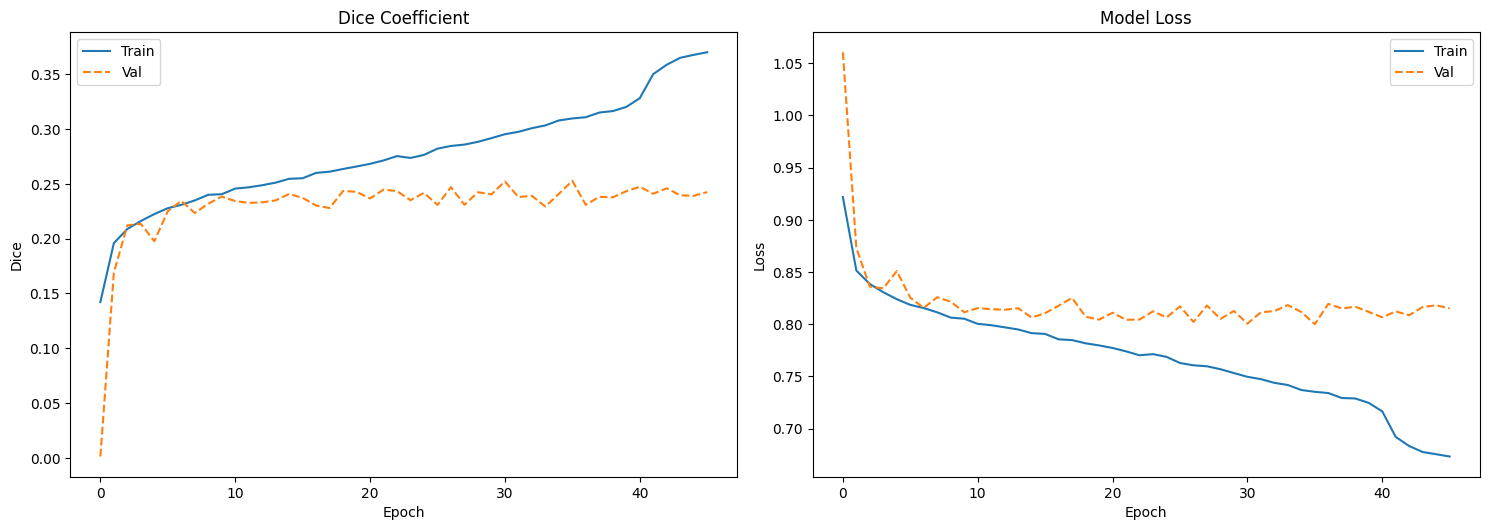


=== Training Summary ===
Best Val Dice: 0.2527 at epoch 36
Final Train Dice: 0.3699
Final Val Dice: 0.2424
No test results found


In [11]:
import shutil
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive

# 1. Mount Google Drive (run this first)
drive.mount('/content/drive')

# 2. Function to save best model to Drive - MODIFIED FOR SINGLE MODEL
def save_best_model_to_drive(local_results_dir='/content/results', drive_dir='/content/drive/MyDrive/HRNet_Models'):
    # Create directory in Drive if it doesn't exist
    os.makedirs(drive_dir, exist_ok=True)

    # Check for the single model and history file
    model_file = os.path.join(local_results_dir, 'best_model.h5')
    history_file = os.path.join(local_results_dir, 'training_history.csv')
    drive_model_path = os.path.join(drive_dir, 'best_model_dice.h5')
    drive_history_path = os.path.join(drive_dir, 'training_history.csv')

    if os.path.exists(model_file) and os.path.exists(history_file):
        # Copy model and its history to Drive
        shutil.copy(model_file, drive_model_path)
        shutil.copy(history_file, drive_history_path)

        # Get best dice from history
        history = pd.read_csv(history_file)
        best_dice = history['val_dice_coef'].max()
        best_epoch = history['val_dice_coef'].idxmax() + 1

        print(f"Saved best model to Drive with val_dice_coef: {best_dice:.4f} (epoch {best_epoch})")
    else:
        print("No model found to save")

# 3. Function to plot training results - MODIFIED FOR SINGLE TRAINING RUN
def plot_training_results(results_dir='/content/results'):
    plt.figure(figsize=(15, 10))

    history_file = os.path.join(results_dir, 'training_history.csv')
    if os.path.exists(history_file):
        history = pd.read_csv(history_file)

        # Plot training and validation dice
        plt.subplot(2, 2, 1)
        plt.plot(history['dice_coef'], label='Train')
        plt.plot(history['val_dice_coef'], '--', label='Val')
        plt.title('Dice Coefficient')
        plt.ylabel('Dice')
        plt.xlabel('Epoch')
        plt.legend()

        # Plot training and validation loss
        plt.subplot(2, 2, 2)
        plt.plot(history['loss'], label='Train')
        plt.plot(history['val_loss'], '--', label='Val')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()

        # Plot learning rate if available
        if 'lr' in history.columns:
            plt.subplot(2, 2, 3)
            plt.plot(history['lr'])
            plt.title('Learning Rate')
            plt.ylabel('LR')
            plt.xlabel('Epoch')

        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print("\n=== Training Summary ===")
        best_epoch = history['val_dice_coef'].idxmax() + 1
        print(f"Best Val Dice: {history['val_dice_coef'].max():.4f} at epoch {best_epoch}")
        print(f"Final Train Dice: {history['dice_coef'].iloc[-1]:.4f}")
        print(f"Final Val Dice: {history['val_dice_coef'].iloc[-1]:.4f}")
    else:
        print("No training history found")

# 4. Function to evaluate and save test set performance - NEW FUNCTION
def save_test_results(results_dir='/content/results', drive_dir='/content/drive/MyDrive/HRNet_Models'):
    test_results_file = os.path.join(results_dir, 'test_results.txt')
    drive_test_path = os.path.join(drive_dir, 'test_results.txt')

    if os.path.exists(test_results_file):
        shutil.copy(test_results_file, drive_test_path)
        with open(test_results_file, 'r') as f:
            print(f.read())
    else:
        print("No test results found")

# 5. Run the functions (after training)
save_best_model_to_drive()
plot_training_results()
save_test_results()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Saved predictions visualization to /content/results/test_predictions.png


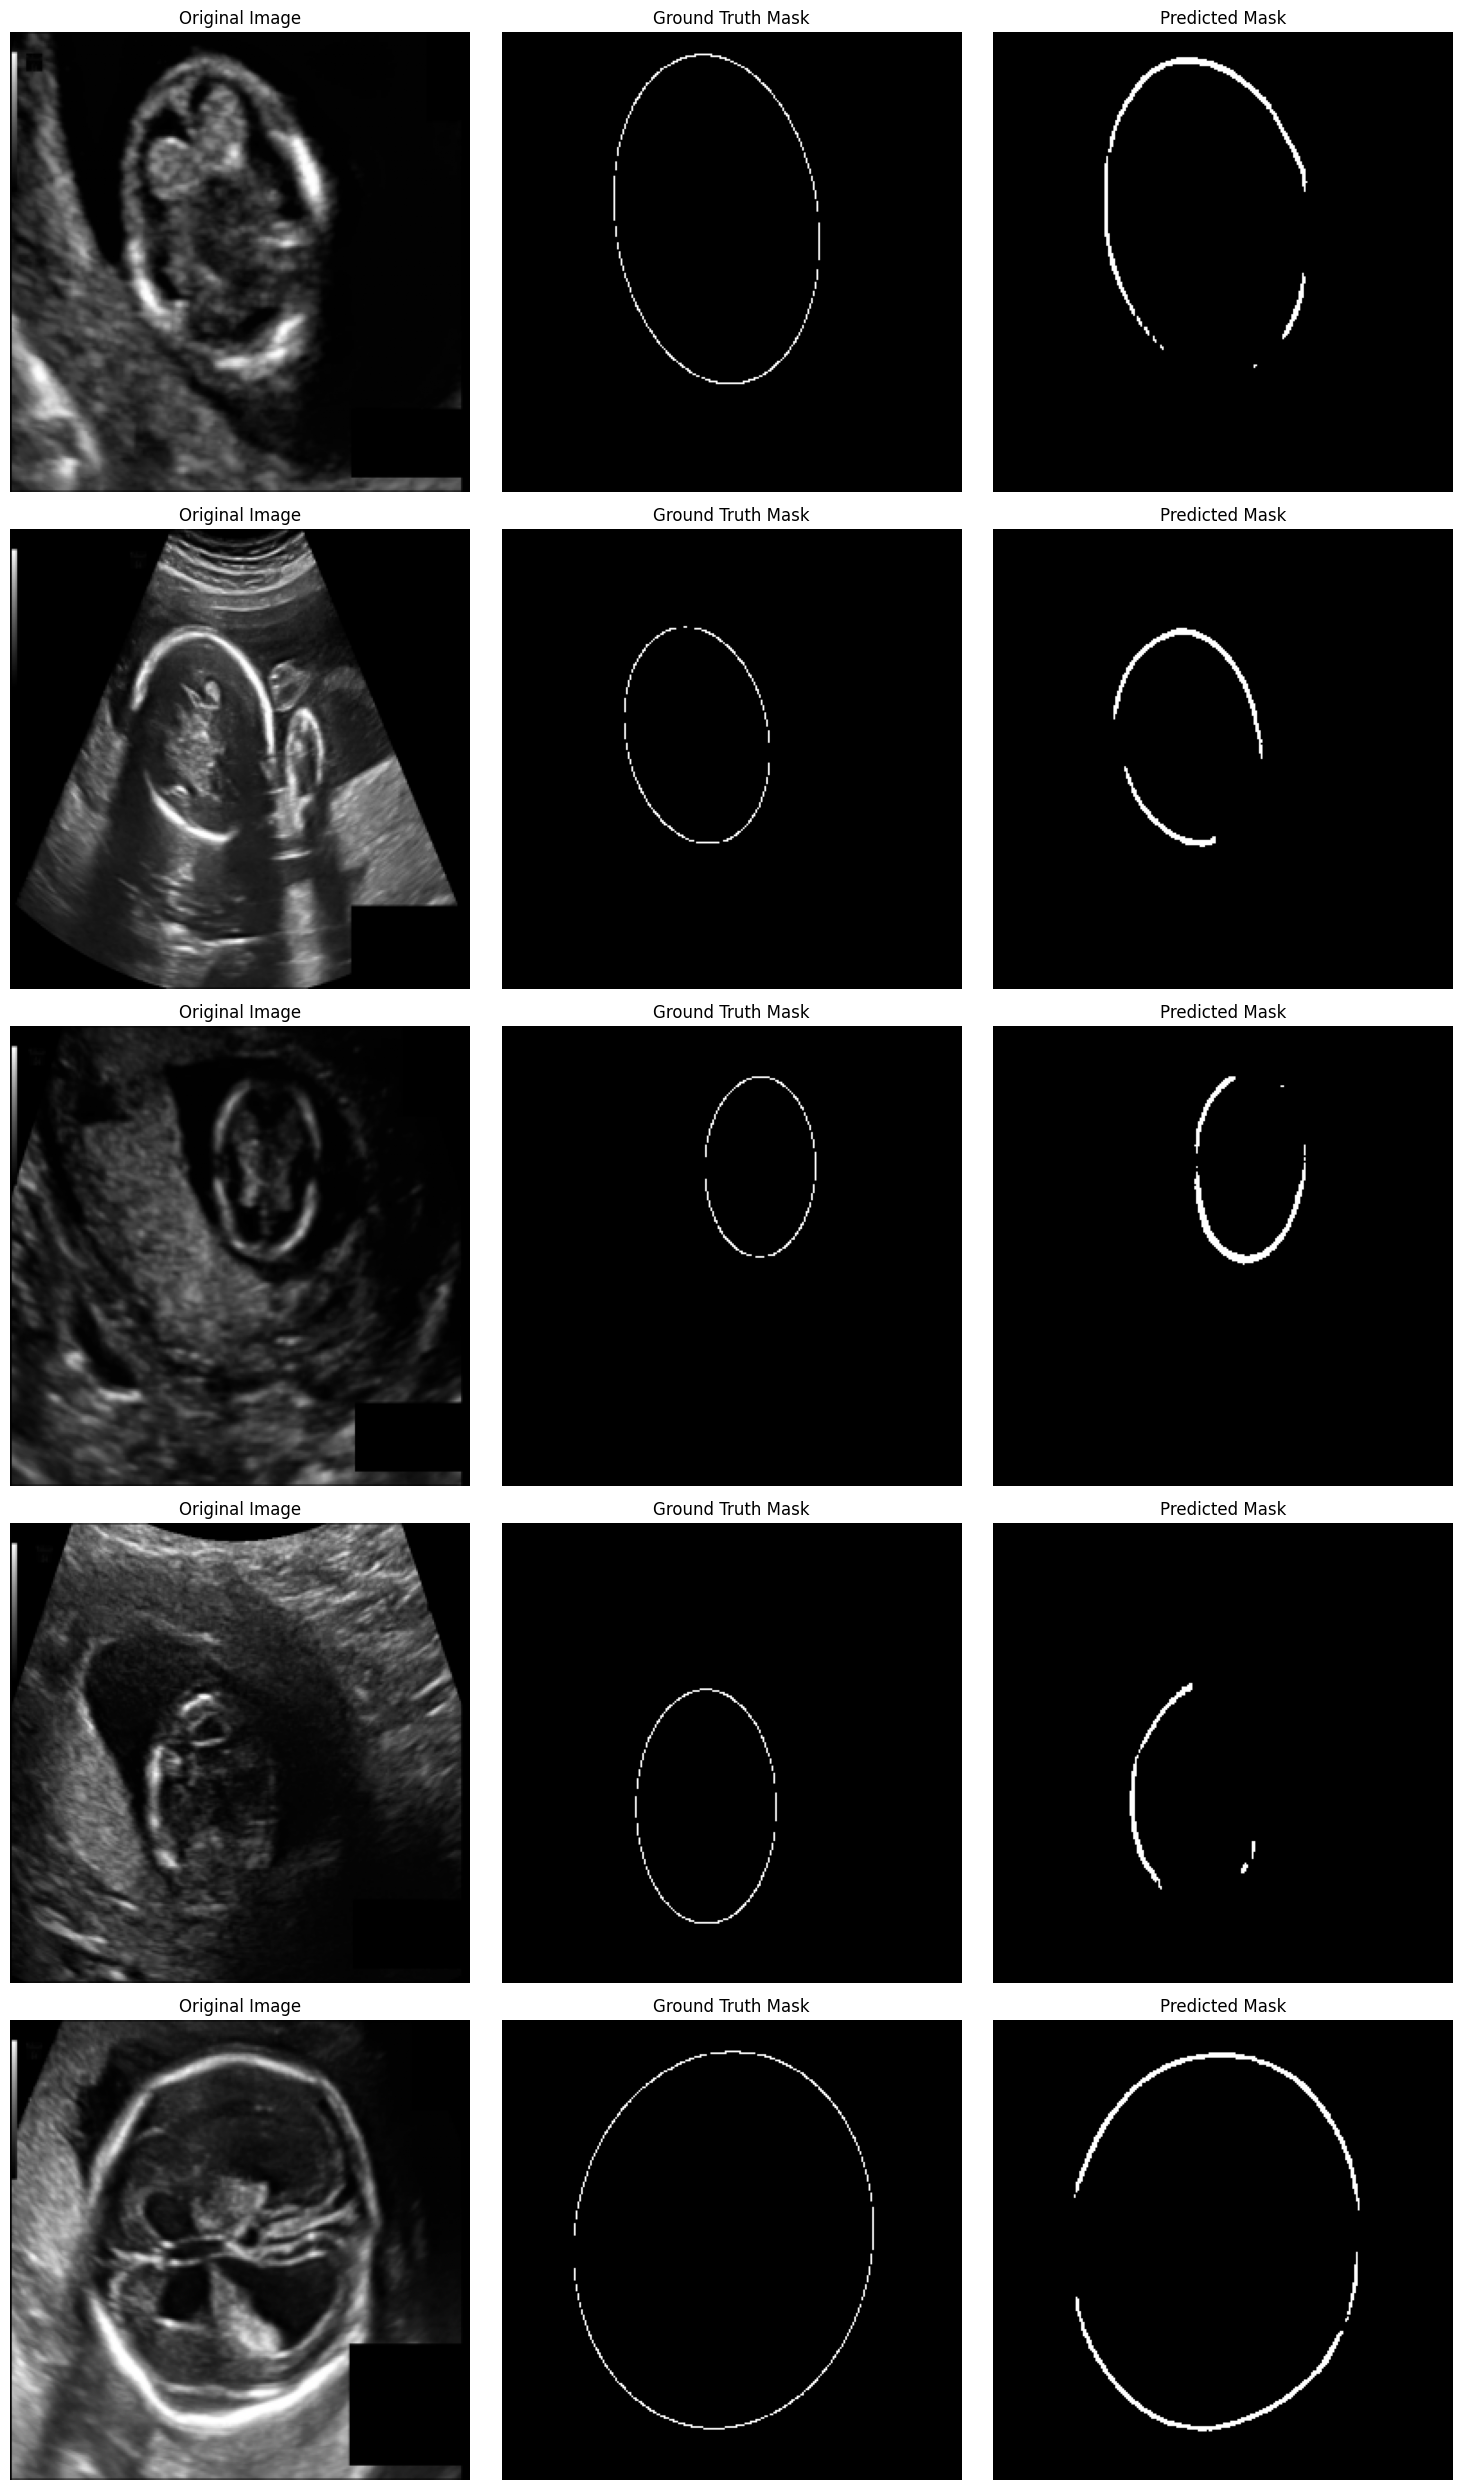

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Saved predictions visualization to /content/drive/MyDrive/HRNet_Models/visualizations/test_predictions.png


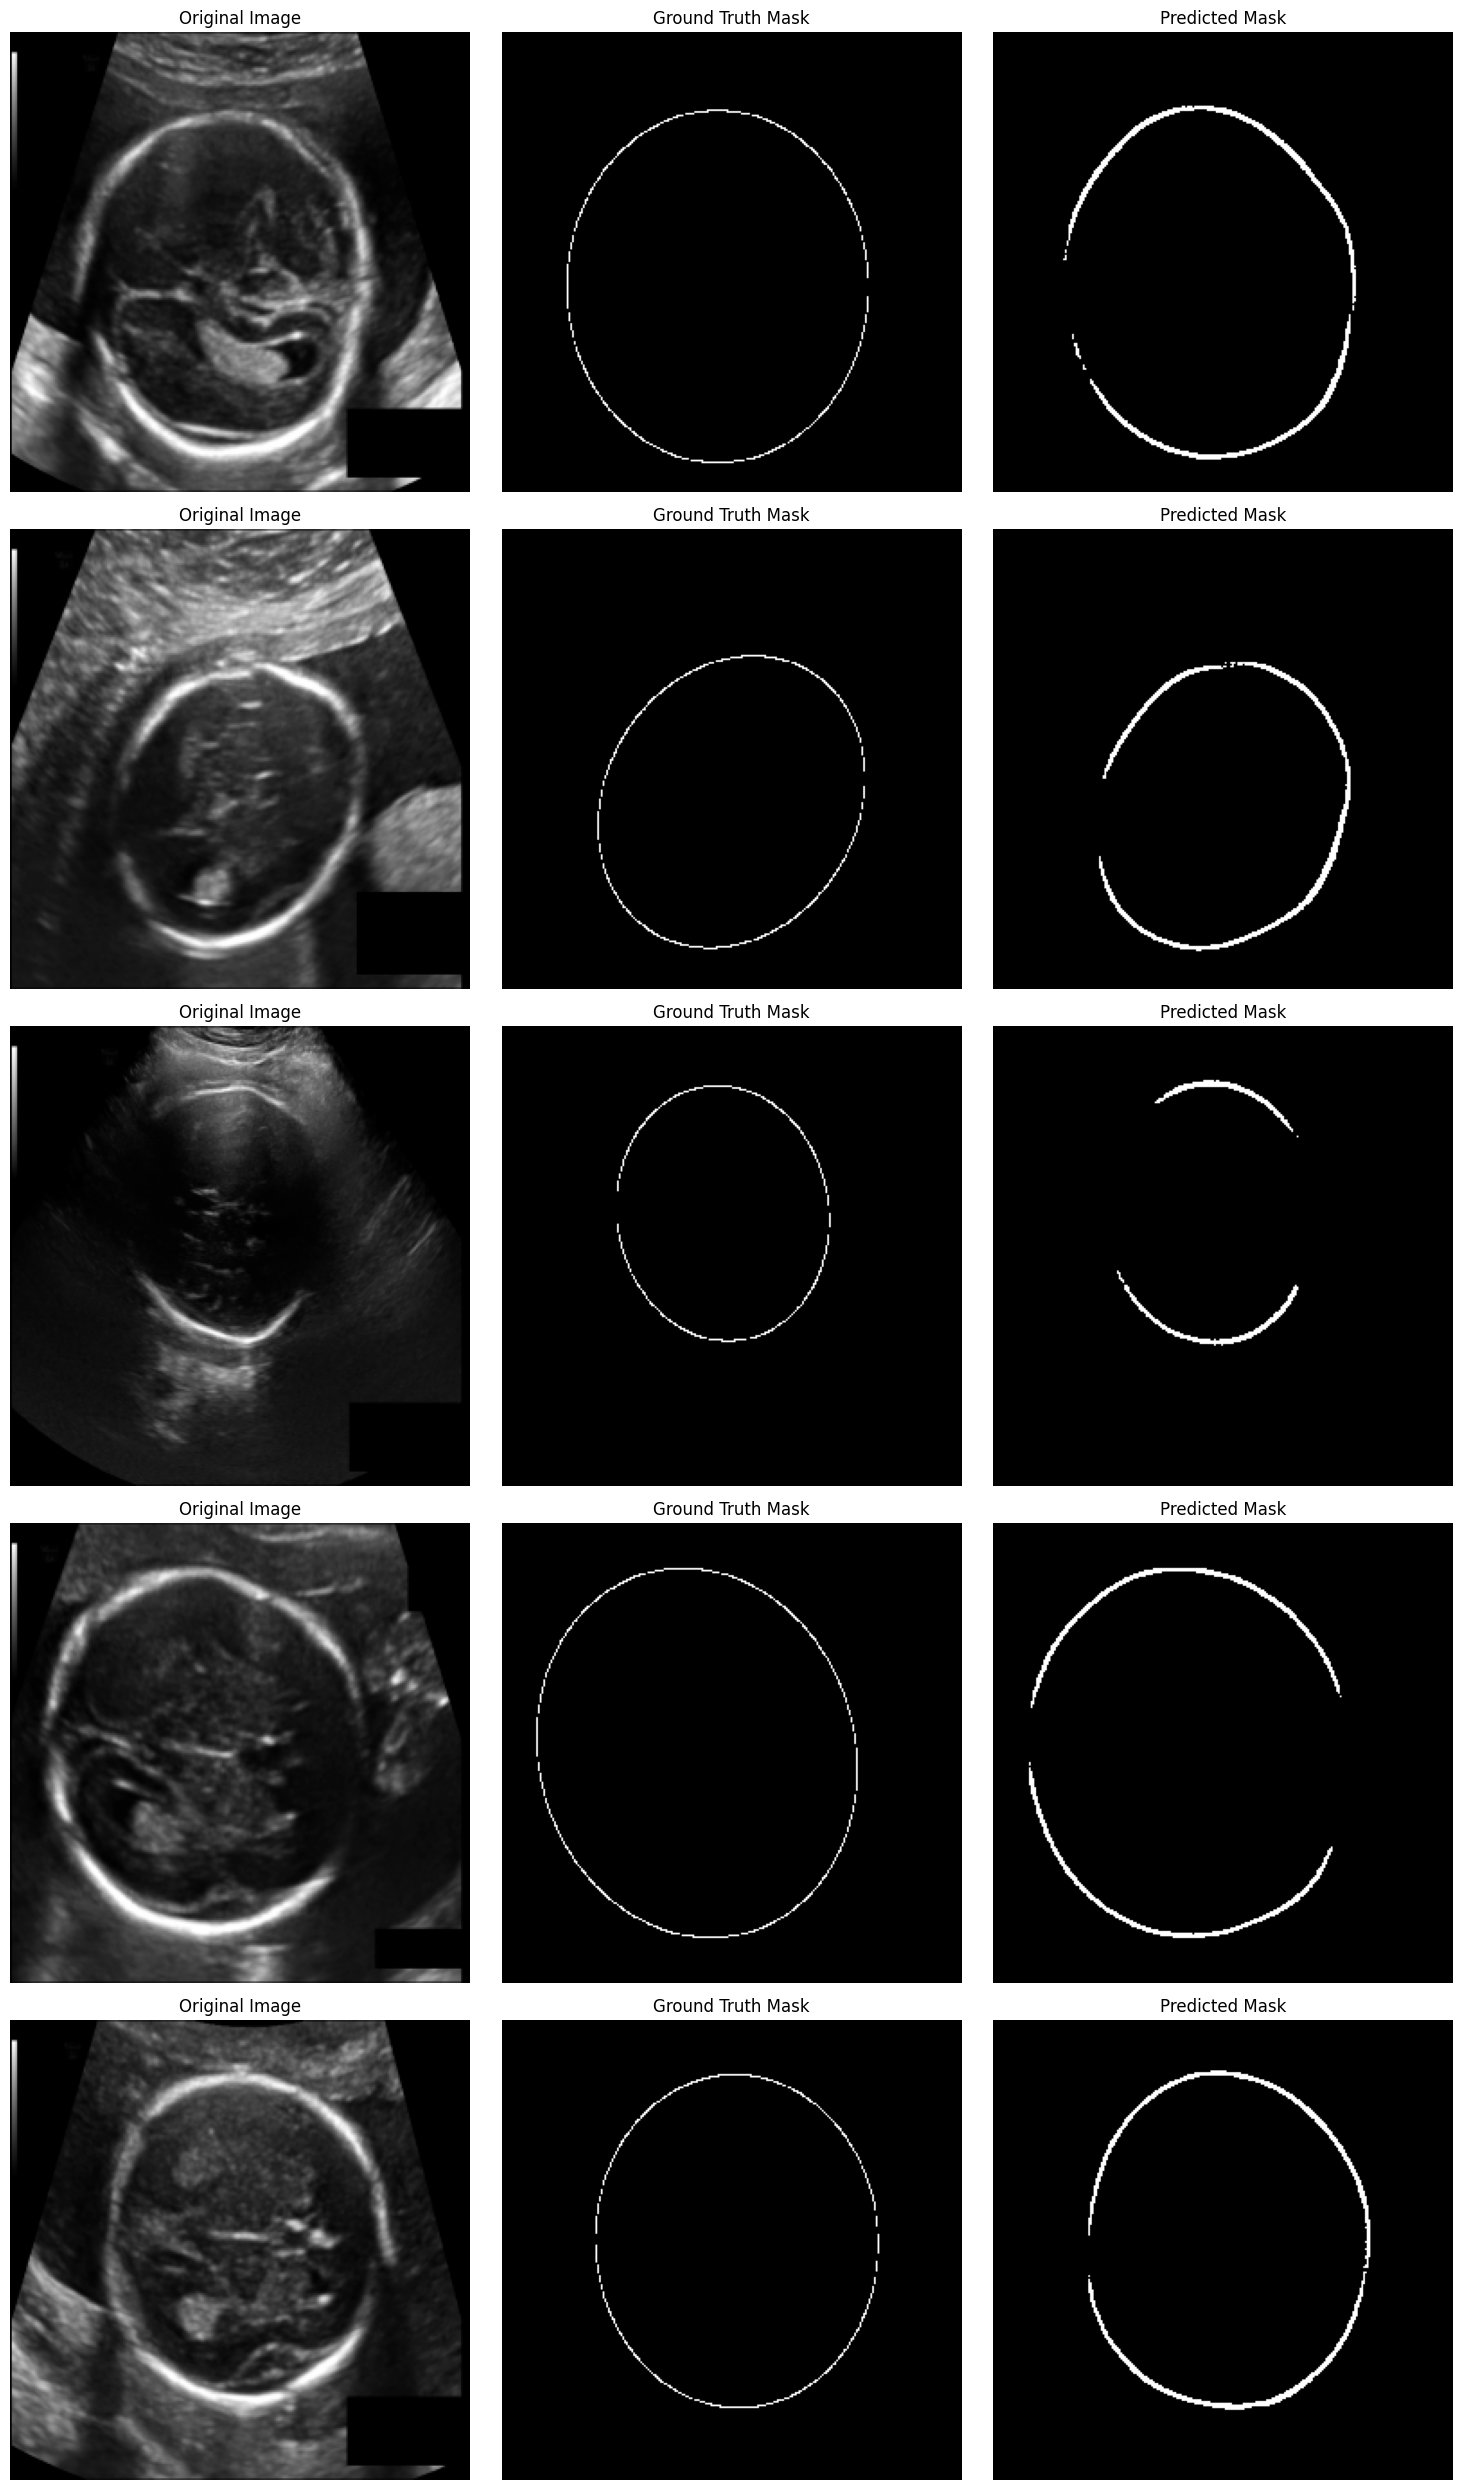

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tensorflow.keras.models import load_model

def visualize_predictions(model, test_images_dir, test_masks_dir, num_samples=5, output_dir=None):
    """
    Visualize model predictions on test images

    Args:
        model: Trained Keras model
        test_images_dir: Directory containing test images
        test_masks_dir: Directory containing test masks
        num_samples: Number of samples to visualize
        output_dir: Directory to save visualizations (optional)
    """
    # Get test image and mask paths
    image_paths = sorted([os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir) if f.endswith('.png')])
    mask_paths = sorted([os.path.join(test_masks_dir, f) for f in os.listdir(test_masks_dir) if f.endswith('.png')])

    # Select random samples
    indices = np.random.choice(len(image_paths), min(num_samples, len(image_paths)), replace=False)

    plt.figure(figsize=(15, 5*num_samples))

    for i, idx in enumerate(indices):
        # Load image and mask
        image = cv2.imread(image_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        # Preprocess image for model
        image_input = np.expand_dims(np.expand_dims(image, axis=-1), axis=0) / 255.0

        # Predict mask
        pred_mask = model.predict(image_input)[0]
        pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255  # Threshold at 0.5

        # Plot results
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()

    # Save visualization if output directory provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, 'test_predictions.png')
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
        print(f"Saved predictions visualization to {output_path}")

    plt.show()

# Usage example (add this after training in your main script):
if __name__ == "__main__":
    # Load your trained model
    model = load_model('/content/results/best_model.h5', custom_objects={
        'dice_coef': dice_coef,
        'dice_loss': dice_loss,
        'bce_dice_loss': bce_dice_loss
    })

    # Define test directories
    test_images_dir = '/content/data/split_preprocessed_256/test/images'
    test_masks_dir = '/content/data/split_preprocessed_256/test/masks'

    # Visualize predictions
    visualize_predictions(
        model=model,
        test_images_dir=test_images_dir,
        test_masks_dir=test_masks_dir,
        num_samples=5,
        output_dir='/content/results'  # Optional: save visualizations
    )

    # Optional: Save to Google Drive
    drive_vis_dir = '/content/drive/MyDrive/HRNet_Models/visualizations'
    visualize_predictions(
        model=model,
        test_images_dir=test_images_dir,
        test_masks_dir=test_masks_dir,
        num_samples=5,
        output_dir=drive_vis_dir
    )